In [1]:
%load_ext autoreload
%autoreload 2
%aimport hpt_cmp

%matplotlib inline

In [2]:
import dataset_loader as ds
import model_loader as mdl
import seaborn as sns

from hpt_cmp import *

from sklearn.metrics import accuracy_score, f1_score,roc_auc_score ,make_scorer
from tqdm import tqdm_notebook


In [3]:
# LOAD DATASETS
ds_names = ['iris', 'wine', 'breast_cancer', 'digits']
datasets = {}

for name in ds_names:
    datasets[name]=(ds.load(name))

In [4]:
models_targs = []

In [44]:
# define MLPClassifier
m = mdl.load_MLPClassifier()
hpt_objs = [
        HPT_OBJ('Baseline', m.base, run_baseline, {}),
        HPT_OBJ('Grid Search', m.param_grid, grid_search, {}),
        HPT_OBJ('Random Search', m.param_grid, random_search, {'n_iter': MAX_ITER}),
        HPT_OBJ('Bayes Seach', m.bayes_grid, baysian_search, {'n_iter':MAX_ITER}),
        HPT_OBJ('Tree of Parzen Est.', m.hyperopt_grid, tpe_search, {})
]
#loss='neg_log_loss'
loss='accuracy'

mlpc ={
    'model': m.model,
    'hpt_objs': hpt_objs,
    'loss': loss,
    'metric': accuracy_score,
}

In [45]:
irisBunch = datasets['iris']
iris = (irisBunch.data, irisBunch.target)

In [15]:


res = cmp_hpt_methods(iris, **mlpc)
res

/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'mean_test_score': [0.9526487663280117], 'std_test_score': [0.02812046444121913], 'mean_train_score': [0.9905660377358491], 'std_train_score': [0.009433962264150941], 'mean_fit_time': [0.07935976982116699], 'std_fit_time': [0.0020797252655029297], 'params': [{'learning_rate': 'adaptive', 'learning_rate_init': 0.01}], 'params_learning_rate': ['adaptive'], 'params_learning_rate_init': [0.01], 'status': ['ok'], 'loss': [0.9526487663280117]}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWa

{'mean_fit_time': array([0.07253575, 0.04249561, 0.00782228, 0.06339574, 0.06072438,
       0.02228165, 0.06470346, 0.03553605, 0.0063262 ]), 'std_fit_time': array([9.37294960e-03, 3.52483988e-02, 5.14984131e-05, 1.14727020e-02,
       2.11890936e-02, 1.44541264e-02, 1.11596584e-02, 1.99382305e-02,
       1.47819519e-03]), 'mean_score_time': array([0.00029016, 0.00049758, 0.00025821, 0.00039077, 0.0005914 ,
       0.00026798, 0.00045156, 0.00038517, 0.00027931]), 'std_score_time': array([6.91413879e-06, 2.55584717e-04, 1.31130219e-05, 1.03950500e-04,
       2.74777412e-04, 4.05311584e-06, 1.26361847e-05, 5.85317612e-05,
       2.46763229e-05]), 'param_learning_rate': masked_array(data=['constant', 'constant', 'constant', 'invscaling',
                   'invscaling', 'invscaling', 'adaptive', 'adaptive',
                   'adaptive'],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 

/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWa

{'mean_fit_time': array([0.07098377, 0.05077744, 0.00580907, 0.07902896, 0.01897049,
       0.04965055, 0.07567167, 0.05883265, 0.00771296]), 'std_fit_time': array([0.01436412, 0.01195598, 0.00108671, 0.01004875, 0.00530529,
       0.03656042, 0.01696658, 0.01184797, 0.0009836 ]), 'mean_score_time': array([0.0022105 , 0.0003022 , 0.00028419, 0.00045598, 0.00031364,
       0.00040424, 0.00064898, 0.00037873, 0.00028765]), 'std_score_time': array([1.92701817e-03, 2.72989273e-05, 2.19345093e-05, 1.65820122e-04,
       1.82390213e-05, 3.73125076e-05, 1.26838684e-04, 8.97645950e-05,
       2.41994858e-05]), 'param_learning_rate_init': masked_array(data=[0.01, 0.3, 0.5, 0.01, 0.3, 0.5, 0.01, 0.3, 0.5],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=['constant', 'constant', 'constant', 'invscaling',
                   'invscaling', 'invscaling', 'ad

/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


defaultdict(<class 'list'>, {'split0_test_score': [0.9433962264150944, 0.9622641509433962, 0.9433962264150944, 0.9245283018867925, 0.9433962264150944, 0.33962264150943394, 0.9245283018867925, 0.9622641509433962, 0.33962264150943394, 0.33962264150943394], 'split1_test_score': [0.9807692307692307, 0.9807692307692307, 0.9807692307692307, 0.9807692307692307, 0.9807692307692307, 0.9807692307692307, 0.9807692307692307, 1.0, 0.9807692307692307, 0.9807692307692307], 'mean_test_score': [0.9619047619047619, 0.9714285714285714, 0.9619047619047619, 0.9523809523809523, 0.9619047619047619, 0.6571428571428571, 0.9523809523809523, 0.9809523809523809, 0.6571428571428571, 0.6571428571428571], 'std_test_score': [0.018685654697434332, 0.009252120287079123, 0.018685654697434332, 0.02811918910778954, 0.018685654697434332, 0.3205587558288011, 0.02811918910778954, 0.018867068820710417, 0.3205587558288011, 0.3205587558288011], 'rank_test_score': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'mean_fit_time': [0.0653152465820

/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/tonia/uni/ml/Hyper-Paramet

{'mean_test_score': [0.34288824383164007, 0.9526487663280117, 0.9715166908563135, 0.9620827285921625, 0.5032656023222061, 0.9715166908563135, 0.9526487663280117, 0.9526487663280117, 0.9620827285921625, 0.9620827285921625], 'std_test_score': [0.0032656023222061015, 0.02812046444121913, 0.009252539912917246, 0.018686502177068187, 0.15711175616835993, 0.009252539912917246, 0.02812046444121913, 0.02812046444121913, 0.018686502177068187, 0.018686502177068187], 'mean_train_score': [0.34288824383164007, 0.9905660377358491, 0.9716981132075472, 0.9905660377358491, 0.4967343976777939, 0.9905660377358491, 1.0, 1.0, 1.0, 1.0], 'std_train_score': [0.0032656023222061015, 0.009433962264150941, 0.028301886792452824, 0.009433962264150941, 0.15711175616835996, 0.009433962264150941, 0.0, 0.0, 0.0, 0.0], 'mean_fit_time': [0.007435202598571777, 0.07104861736297607, 0.0632866621017456, 0.06555438041687012, 0.016185879707336426, 0.07919883728027344, 0.06617140769958496, 0.06902158260345459, 0.076325416564941

/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tonia/uni/ml/Hyper-Parameter-Tuning/env/lib64/python3.6/site-packages/sklearn/uti

[{'method': 'Baseline',
  'data': {'mean_test_score': [0.9526487663280117],
   'std_test_score': [0.02812046444121913],
   'mean_train_score': [0.9905660377358491],
   'std_train_score': [0.009433962264150941],
   'mean_fit_time': [0.07935976982116699],
   'std_fit_time': [0.0020797252655029297],
   'params': [{'learning_rate': 'adaptive', 'learning_rate_init': 0.01}],
   'params_learning_rate': ['adaptive'],
   'params_learning_rate_init': [0.01],
   'status': ['ok'],
   'loss': [0.9526487663280117]},
  'best_params': {'learning_rate': 'adaptive', 'learning_rate_init': 0.01},
  'conf_matrix': array([[14,  0,  0],
         [ 0, 16,  1],
         [ 0,  0, 14]])},
 {'method': 'Grid Search',
  'data': {'mean_fit_time': array([0.07253575, 0.04249561, 0.00782228, 0.06339574, 0.06072438,
          0.02228165, 0.06470346, 0.03553605, 0.0063262 ]),
   'std_fit_time': array([9.37294960e-03, 3.52483988e-02, 5.14984131e-05, 1.14727020e-02,
          2.11890936e-02, 1.44541264e-02, 1.11596584e-02,

In [22]:
methods = []
dfs = {}

for data in res:
    methods.append(data['method'])
    dfs[data['method']]=(pd.DataFrame(data['data']))
df = pd.DataFrame(res[2]['data']).sort_values(by=['mean_test_score'], ascending=False)
l = [i for i in range(len(df.index))]
print(l)
df.set_index([l, 'mean_test_score'])

# i =np.argmax()
# res[1]['data']['params'][i]
res[1]

[0, 1, 2, 3, 4, 5, 6, 7, 8]


{'method': 'Grid Search',
 'data': {'mean_fit_time': array([0.07253575, 0.04249561, 0.00782228, 0.06339574, 0.06072438,
         0.02228165, 0.06470346, 0.03553605, 0.0063262 ]),
  'std_fit_time': array([9.37294960e-03, 3.52483988e-02, 5.14984131e-05, 1.14727020e-02,
         2.11890936e-02, 1.44541264e-02, 1.11596584e-02, 1.99382305e-02,
         1.47819519e-03]),
  'mean_score_time': array([0.00029016, 0.00049758, 0.00025821, 0.00039077, 0.0005914 ,
         0.00026798, 0.00045156, 0.00038517, 0.00027931]),
  'std_score_time': array([6.91413879e-06, 2.55584717e-04, 1.31130219e-05, 1.03950500e-04,
         2.74777412e-04, 4.05311584e-06, 1.26361847e-05, 5.85317612e-05,
         2.46763229e-05]),
  'param_learning_rate': masked_array(data=['constant', 'constant', 'constant', 'invscaling',
                     'invscaling', 'invscaling', 'adaptive', 'adaptive',
                     'adaptive'],
               mask=[False, False, False, False, False, False, False, False,
                

In [21]:
dfs[methods[-1]].drop(['loss', 'status'], 1)
dfs[methods[-1]]

,mean_test_score,std_test_score,mean_train_score,std_train_score,mean_fit_time,std_fit_time,params,params_learning_rate,params_learning_rate_init,status,loss
0,0.342888,0.003266,0.342888,0.003266,0.007435,0.000140,"{'learning_rate': 'adaptive', 'learning_rate_i...",adaptive,0.50,ok,0.342888
1,0.952649,0.028120,0.990566,0.009434,0.071049,0.012907,"{'learning_rate': 'adaptive', 'learning_rate_i...",adaptive,0.01,ok,0.952649
2,0.971517,0.009253,0.971698,0.028302,0.063287,0.006683,"{'learning_rate': 'constant', 'learning_rate_i...",constant,0.30,ok,0.971517
3,0.962083,0.018687,0.990566,0.009434,0.065554,0.003842,"{'learning_rate': 'constant', 'learning_rate_i...",constant,0.30,ok,0.962083
4,0.503266,0.157112,0.496734,0.157112,0.016186,0.006658,"{'learning_rate': 'adaptive', 'learning_rate_i...",adaptive,0.50,ok,0.503266
5,0.971517,0.009253,0.990566,0.009434,0.079199,0.005886,"{'learning_rate': 'invscaling', 'learning_rate...",invscaling,0.30,ok,0.971517
6,0.952649,0.028120,1.000000,0.000000,0.066171,0.009639,"{'learning_rate': 'invscaling', 'learning_rate...",invscaling,0.01,ok,0.952649
7,0.952649,0.028120,1.000000,0.000000,0.069022,0.010548,"{'learning_rate': 'adaptive', 'learning_rate_i...",adaptive,0.01,ok,0.952649
8,0.962083,0.018687,1.000000,0.000000,0.076325,0.005440,"{'learning_rate': 'invscaling', 'learning_rate...",invscaling,0.01,ok,0.962083
9,0.962083,0.018687,1.000000,0.000000,0.063075,0.010272,"{'learning_rate': 'constant', 'learning_rate_i...",constant,0.01,ok,0.962083


In [17]:
n = 'name'
mts = 'mean_test_score'
mft = 'mean_fit_time'
all_df = pd.DataFrame(columns=[n, mts, mft, 'params_sampled'])
for i, m in enumerate(methods[1:4]):
    all_df.loc[i] = [m, dfs[m][mts].mean(), dfs[m][mft].mean(),len(dfs[m].index)]
all_df

,name,mean_test_score,mean_fit_time,params_sampled
0,Grid Search,0.767196,0.041758,9
1,Random Search,0.728042,0.046382,9
2,Bayes Seach,0.871429,0.056709,10


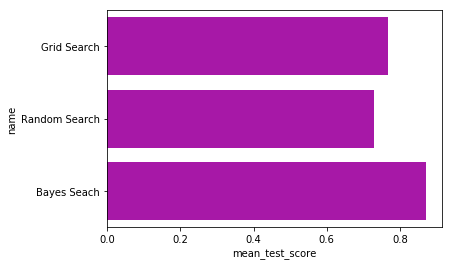

In [18]:
sns.barplot(x=mts, y=n, data=all_df, color='m')


In [19]:
conf_m = [[497, 52],[108, 234]]
conf_m = np.array(conf_m)
normalised = conf_m.astype('float')/ conf_m.sum(axis=1)[:,np.newaxis]

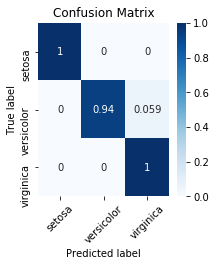

In [48]:
r = []
for i in res:
    plt.figure()
    r.append()
    plot_confusion_matrix(i['conf_matrix'], classes=irisBunch.target_names)
g = sns.FacetGrid(r)


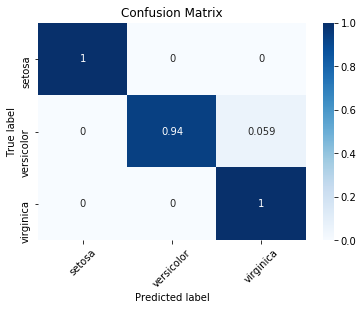

In [49]:
plot_confusion_matrix(r[0], classes=irisBunch.target_names)

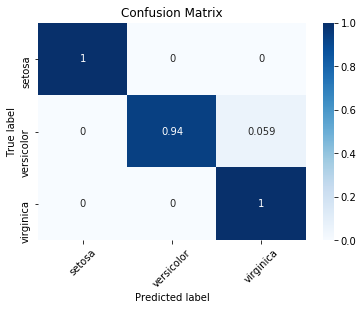

In [50]:
plot_confusion_matrix(r[1], classes=irisBunch.target_names)

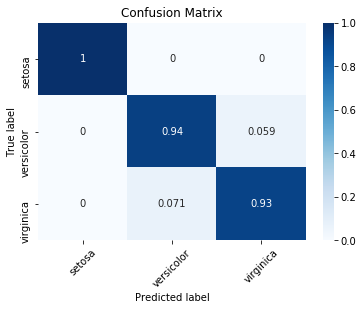

In [51]:
plot_confusion_matrix(r[3], classes=irisBunch.target_names)

In [ ]:
# plot confusion matrix 

sns.heatmap(normalised, annot=True,annot_kws={"size": 16}, cmap=plt.cm.Blues)

In [ ]:
sns.barplot(x=(('params_sampled')), y=n, data=all_df)

In [ ]:
sns.barplot(x=mft, y=n, data=all_df, color='m')

In [ ]:
# define SVC
m = mdl.load_SVC()
hpt_objs = [
        HPT_OBJ('Baseline', m.base, run_baseline, {}),
        HPT_OBJ('Grid Search', m.param_grid, grid_search, {}),
        HPT_OBJ('Random Search', m.param_grid, random_search, {'n_iter': MAX_ITER}),
        HPT_OBJ('Bayes Seach', m.bayes_grid, baysian_search, {'n_iter':MAX_ITER}),
        HPT_OBJ('Tree of Parzen Est.', m.hyperopt_grid, tpe_search, {})
]
loss=None

models_targs.append({
    'model': m.model,
    'htp_objs': hpt_objs,
    'loss': loss,
    'metric': accuracy_score,
})

In [ ]:
# define SVC
m = mdl.load_RandomForestClassifier()
hpt_objs = [
        HPT_OBJ('Baseline', m.base, run_baseline, {}),
        HPT_OBJ('Grid Search', m.param_grid, grid_search, {}),
        HPT_OBJ('Random Search', m.param_grid, random_search, {'n_iter': MAX_ITER}),
       # HPT_OBJ('Bayes Seach', m.bayes_grid, baysian_search, {'n_iter':MAX_ITER}),
       # HPT_OBJ('Tree of Parzen Est.', m.hyperopt_grid, tpe_search, {})
]
loss=None

models_targs.append({
    'model': m.model,
    'htp_objs': hpt_objs,
    'loss': loss,
    'metric': accuracy_score,
})

In [ ]:
# RUN TUNING
all_results = []

for m_args in models_targs:
    for name in datasets:
        d = datasets[name]
        try:
            result = cmp_hpt_methods(
                (d.data, d.target),
                **m_args,
                random_state=1,
                name=name
            )
            all_results.append(result)
        except Exception as e:
            print('!!!!!!!!!!!!!!!!!!')
            print(m.model.__name__,name)
            print(e)


In [ ]:
len(all_results)

In [ ]:
 
table_by_ds(all_results[0:4], ds_names)

In [ ]:
for x in [MEAN+CV_TIME, MEAN+TEST_ACC]:
    plot_by_ds(x, all_results[0:4], ds_names)
    plot_by_ds(x, all_results[4:8], ds_names)
    #plot_by_ds(x, all_results[8:12], ds_names)

In [ ]:
pd.DataFrame(all_results[0])